## Imports

In [612]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

## Definindo DataSet

In [613]:
data_set = load_iris()
df = pd.DataFrame(data=data_set.data, columns=data_set.feature_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [614]:
X, y = data_set['data'], data_set['target']
X.shape, y.shape, np.unique(y, return_counts=True)

((150, 4), (150,), (array([0, 1, 2]), array([50, 50, 50])))

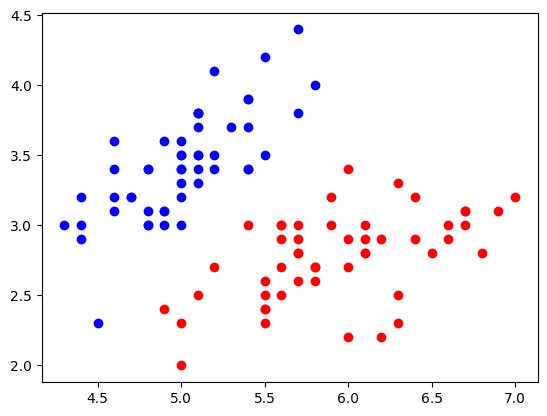

In [615]:
plt.scatter(X[:,0][y==0], X[:,1][y==0], color='blue')
plt.scatter(X[:,0][y==1], X[:,1][y==1], color='red')

# Multilayer perceptron

In [616]:
class MLP():
    def __init__(self, X:np.ndarray, y:np.ndarray, hidden_neurons:int, output_neurons:int) -> None:
        self.X = X
        self.y = y

        self.input_neurons = X.shape[1]
        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons

        # camada inicial para camada oculta
        self.f1 = None
        self.w1 = np.random.randn(self.input_neurons, self.hidden_neurons)
        self.b1 = np.zeros((1, self.hidden_neurons)) # bias

        # camada oculta para saida
        self.f2 = None
        self.w2 = np.random.randn(self.hidden_neurons, self.output_neurons)
        self.b2 = np.zeros((1, self.output_neurons))

    def predict(self):
        pass

    def fit(self, ephocs:int, learning_rate:float) -> None:
        """Realiza o treinamento da rede."""
        for e in range(ephocs):
            output = self.__feedfoward(self.X)
            loss = self.__loss_function(output)

            # Condição de parada
            if loss == 0:
                print(f'Perda atingiu zero após {e} épocas. Treinamento concluído.')
                break
            else:
                accuracy = self.__calc_accuracy(output)
                print(f'Época: {e} \t Acertos: {accuracy} \tPerda: {loss}')

            self.__backpropagation(output, learning_rate)

    def __feedfoward(self, X:np.ndarray) -> np.ndarray:
        """Realiza a propagação direta pela rede neural."""
        z1 = X @ self.w1 + self.b1 # broadcasting
        self.f1 = self.__activation_function(z1, layer='hidden')
        
        z2 = self.f1 @ self.w2 + self.b2
        self.f2 = self.__activation_function(z2, layer='output')

        return self.f2

    def __activation_function(self,input:np.ndarray, layer:str) -> np.ndarray:
        """Aplica a função de ativação à saída da camada especificada.:
            Valores possíveis:
                - 'hidden': Camada oculta, usa a função tangente hiperbólica.
                - 'output': Camada de saída, usa a função softmax.
        """
        if layer == 'hidden':
            return np.tanh(input)
        elif layer == 'output':
            exp_values = np.exp(input - np.max(input, axis=1, keepdims=True))
            return exp_values / np.sum(exp_values, axis=1, keepdims=True)
        else:
            raise ValueError("O argumento 'layer' deve ser 'hidden' ou 'output'.")
    
    def __loss_function(self, predictions:np.ndarray) -> float:
        """Calcula a perda da rede neural usando a Cross-Entropy Categórica."""
        num_samples = predictions.shape[0]
        loss = -np.sum(self.y.reshape(-1, 1) * np.log(predictions)) / num_samples
        return loss

    def __backpropagation(self, predictions:np.ndarray, learning_rate:float) -> None:
        """Executa o algoritmo de backpropagation para atualizar os pesos."""
        # Calcula o gradiente da perda em relação à saída
        grad_loss_output = predictions - self.y.reshape(-1, 1)
        
        # Gradientes da camada de saída
        grad_w2 = self.f1.T @ grad_loss_output
        grad_b2 = np.sum(grad_loss_output, axis=0, keepdims=True)

        # Calcula o gradiente da perda em relação à entrada da camada oculta
        grad_loss_hidden = (grad_loss_output @ self.w2.T) * (1 - np.power(self.f1, 2))
        
        # Gradientes da camada oculta
        grad_w1 = self.X.T @ grad_loss_hidden
        grad_b1 = np.sum(grad_loss_hidden, axis=0, keepdims=True)

        # Atualiza os pesos e bias das respectivas camadas
        self.w2 -= learning_rate * grad_w2
        self.b2 -= learning_rate * grad_b2
        self.w1 -= learning_rate * grad_w1
        self.b1 -= learning_rate * grad_b1

    def __calc_accuracy(self, predictions:np.ndarray) -> float:
        """Calcula a porcentagem de acertos do modelo."""
        predicted_labels = np.argmax(predictions, axis=1)
        true_labels = (predicted_labels == self.y).sum()
        accuracy = true_labels / self.X.shape[0]
        return np.round(accuracy, 3) 



## Testes

In [617]:
model = MLP(X, y, 10, 2)
model.fit(100, 0.001)

Época: 0 	 Acertos: 0.333 	Perda: 6.862569355718997
Época: 1 	 Acertos: 0.333 	Perda: 337.78327672936905
Época: 2 	 Acertos: 0.333 	Perda: 4.8516206745615635
Época: 3 	 Acertos: 0.333 	Perda: 1.642942243850919
Época: 4 	 Acertos: 0.333 	Perda: 1.386720743084602
Época: 5 	 Acertos: 0.333 	Perda: 9.715736447976843
Época: 6 	 Acertos: 0.333 	Perda: 1.394255816296158
Época: 7 	 Acertos: 0.333 	Perda: 1.3931106081845168
Época: 8 	 Acertos: 0.333 	Perda: 1.3921296119100768
Época: 9 	 Acertos: 0.333 	Perda: 1.391289419671291
Época: 10 	 Acertos: 0.333 	Perda: 1.3905699233909692
Época: 11 	 Acertos: 0.333 	Perda: 1.3899538594424388
Época: 12 	 Acertos: 0.333 	Perda: 1.9608861445793464
Época: 13 	 Acertos: 0.333 	Perda: 1.3866004092123991
Época: 14 	 Acertos: 0.333 	Perda: 1.386556229778954
Época: 15 	 Acertos: 0.333 	Perda: 1.3865184270744229
Época: 16 	 Acertos: 0.333 	Perda: 1.3864860809076864
Época: 17 	 Acertos: 0.333 	Perda: 10.027240330964247
Época: 18 	 Acertos: 0.333 	Perda: 1.38769574